# Scale Triangle Meshes

The idea of this notebook is to show how the script [scale_meshes.py](../apps/scale_meshes.py) works internally.

The idea is to scale all input meshes to lie on a small cube.

In [1]:
import open3d as o3d
import open3d_jupyter_draw_geometries
import copy
import os
import numpy as np

Original Mesh:
TriangleMesh with 14396 points and 4821 triangles.
Boundig Box: [(-0.5906, -20.0222, -0.0012) - (20.8258, 0.0061, 38.1103)]


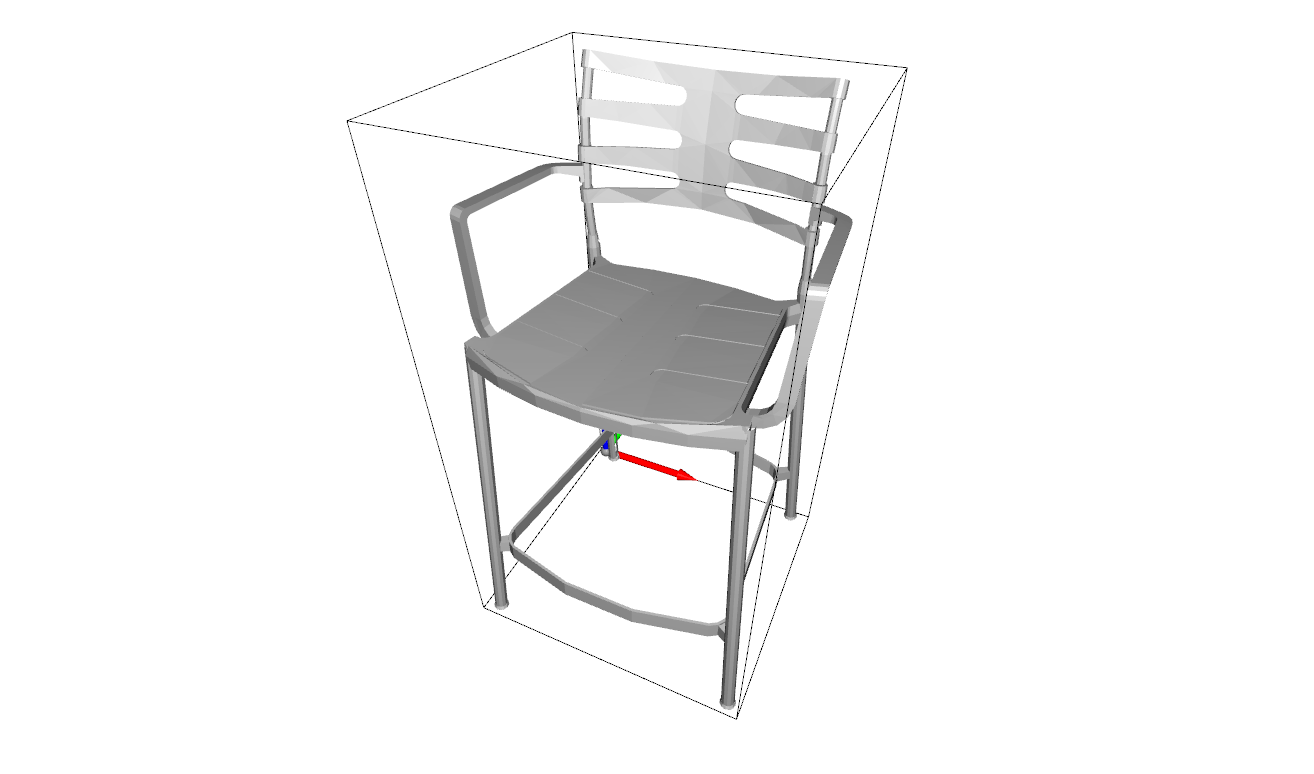

In [2]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(10)
mesh = o3d.io.read_triangle_mesh('../tests/test_data/chair_0891.off')
mesh.compute_vertex_normals()
bbox = mesh.get_axis_aligned_bounding_box()
print("Original Mesh:")
print(mesh)
print("Boundig Box:", bbox.get_print_info())

o3d.visualization.draw_geometries([mesh, bbox, origin],
                                  front=[0.32, -0.71, 0.63],
                                  lookat=[10.12, -10.01, 19.05],
                                  up=[-0.26, 0.57, 0.78],
                                  zoom=0.68)

## Mesh Volume

There are many ways of computing the bounding volume of the mesh, but given that we have already computed the bounding box of the model, the easiest way is to multiply the extent of the bounding_box.

Here we also show how to create a dense box, representing the bounding volme of the object, and allso call the `get_volume()` to check the results

Volume of the mesh, method#1:16347.35
Volume of the mesh: method#1:16347.35


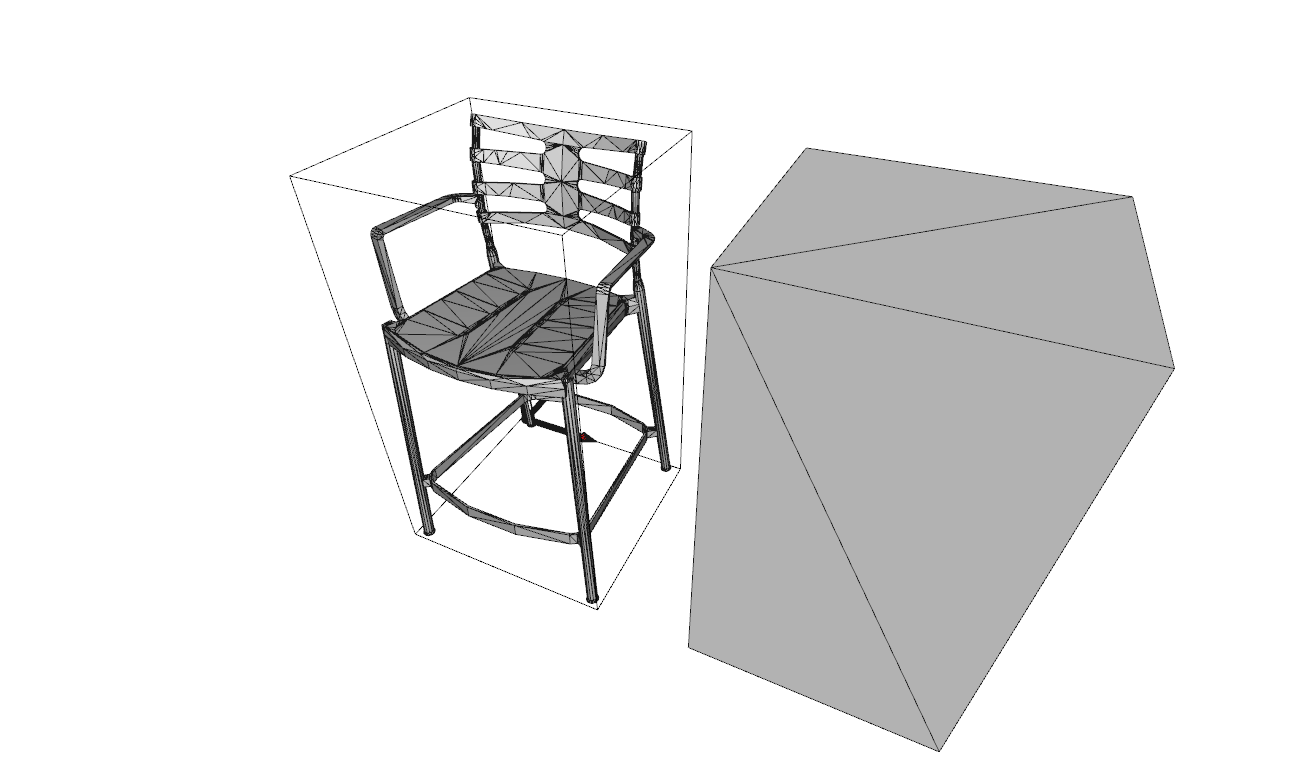

In [3]:
# Method 1, easy
print("Volume of the mesh, method#1:{:.2f}".format(bbox.get_extent().prod()))

# Method 2, tricky
bounding_volume = o3d.geometry.TriangleMesh.create_box(
    width=bbox.get_extent()[0],
    height=bbox.get_extent()[1],
    depth=bbox.get_extent()[2],
)
print("Volume of the mesh: method#1:{:.2f}".format(
    bounding_volume.get_volume()))

bounding_volume.translate([30, -20, 0])
o3d.visualization.draw_geometries([origin, mesh, bbox, bounding_volume],
                                  mesh_show_wireframe=True,
                                  front=[0.32, -0.71, 0.63],
                                  lookat=[20.92, -6.82, 17.15],
                                  up=[-0.26, 0.57, 0.78],
                                  zoom=0.68)

## scale_mesh()

First let's see how the full implementation affect this input mesh, it basically consist in 4 steps:

  1. Compute the Axis Aligned Bounding Box of the model (AABB)
  1. Translate the mesh to the origin by subtracting the center of the AABB to all vertices.
  1. Get the maximum extent of the bounding_box(max distance to the origin of any vertex in the model). And use this to normalize the model forcing it to fit into a unit sphere.
  1. Rescale the model with `scale` parameter, typically set to `1` and add some padding to make sure it's a bit smaller than the unit sphere equivalent
  
```python
def scale_mesh(mesh, scale=1, padding=0.1):
    """Scale the input mesh into a unit sphere."""
    # Get bbox of original mesh
    bbox = mesh.get_axis_aligned_bounding_box()

    # Translate the mesh
    scaled_mesh = copy.deepcopy(mesh)
    scaled_mesh.translate(-bbox.get_center())
    scaled_mesh.scale(2 / bbox.get_max_extent(), center=[0, 0, 0])
    scaled_mesh.scale(scale * (1 - padding), center=[0, 0, 0])
    return scaled_mesh
```

In [4]:
from vdb_to_numpy.utils import scale_mesh

Scaled Mesh: TriangleMesh with 14396 points and 4821 triangles.
Volume of the mesh:2.36
Boundig Box: [(-0.5619, -0.5255, -1.0000) - (0.5619, 0.5255, 1.0000)]


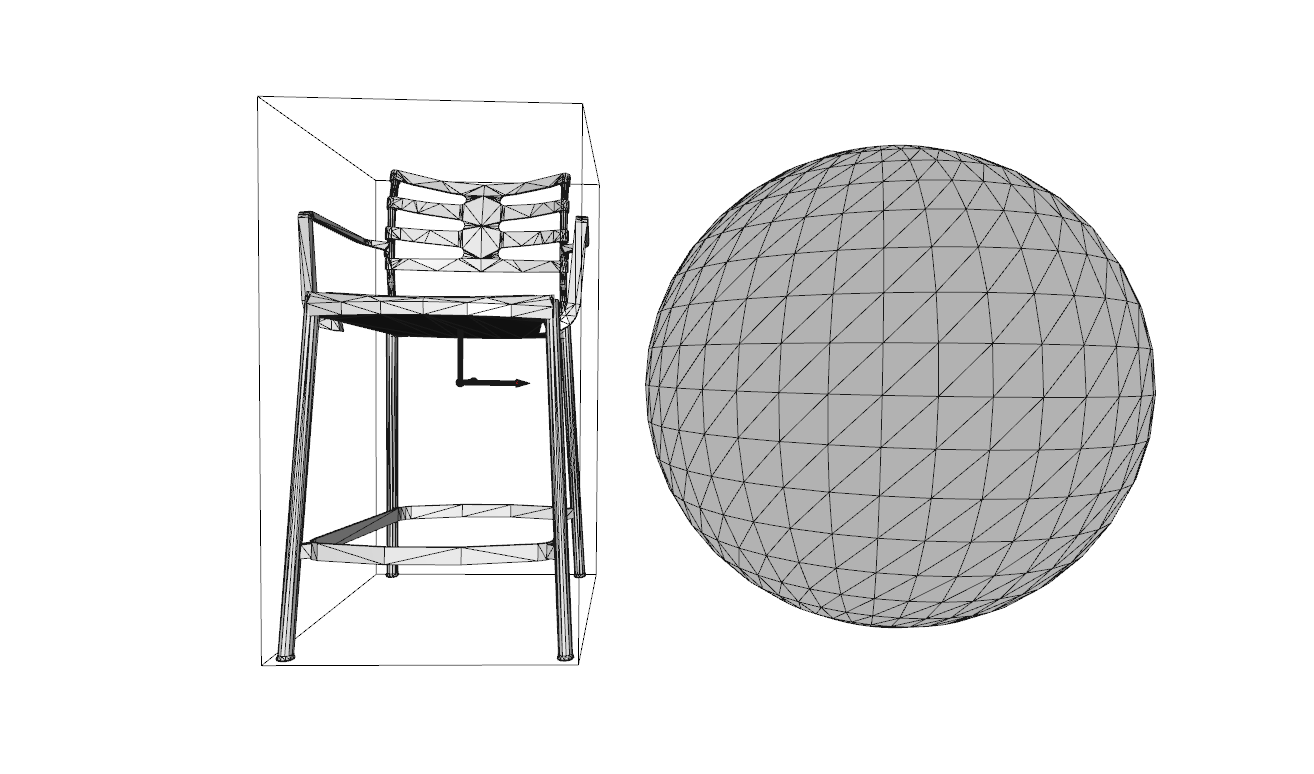

In [5]:
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(0.3)
scaled_mesh = scale_mesh(mesh, scale=1, padding=0)
scaled_bbox = scaled_mesh.get_axis_aligned_bounding_box()

print("Scaled Mesh:", scaled_mesh)
print("Volume of the mesh:{:.2f}".format(scaled_bbox.get_extent().prod()))
print("Boundig Box:", scaled_bbox.get_print_info())

# As a reference, let's add a unit sphere to the plot
unit_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
unit_sphere.translate([1.8, 0, 0])
o3d.visualization.draw_geometries([origin, unit_sphere, scaled_mesh, scaled_bbox],
                                  mesh_show_wireframe=True,
                                  front=[-0.03, -1.0, 0.03],
                                  lookat=[0.85, -0.01, -0.01],
                                  up=[-0.01, 0.03, 1.0],
                                  zoom=0.5)

At first, it doesn't look that it did anything (which is actually good) but now let's plot both meshes at the same time

Scaled and Original Mesh(close up):


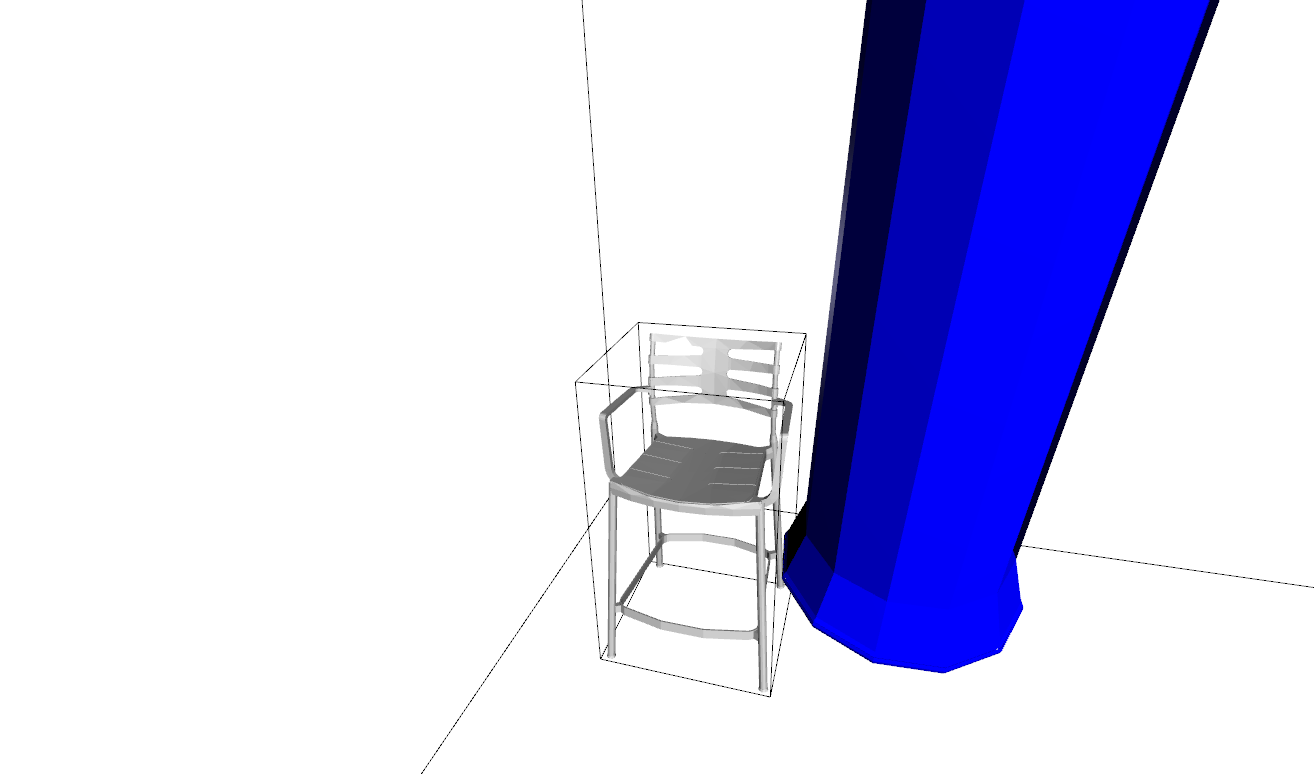

In [6]:
print("Scaled and Original Mesh(close up):")
original_mesh = copy.deepcopy(mesh)
original_mesh.paint_uniform_color([0, 0, 1])
o3d.visualization.draw_geometries([original_mesh, bbox, scaled_mesh, scaled_bbox],
                                  show_coordinate_frame=True,
                                  front=[0.29, -0.87, 0.4],
                                  lookat=[-0.65, 1.14, 0.25],
                                  up=[-0.09, 0.39, 0.91],
                                  zoom=0.08)

## Compare more meshes

The idea of this scaling is to make all the meshes fit into the same volume, let's see how that works

Before scaling:
Volume of the mesh 1 = 16347.35
Volume of the mesh 2 = 12352149460.85
After scaling:
Volume of the mesh 1 = 1.72
Volume of the mesh 2 = 2.55


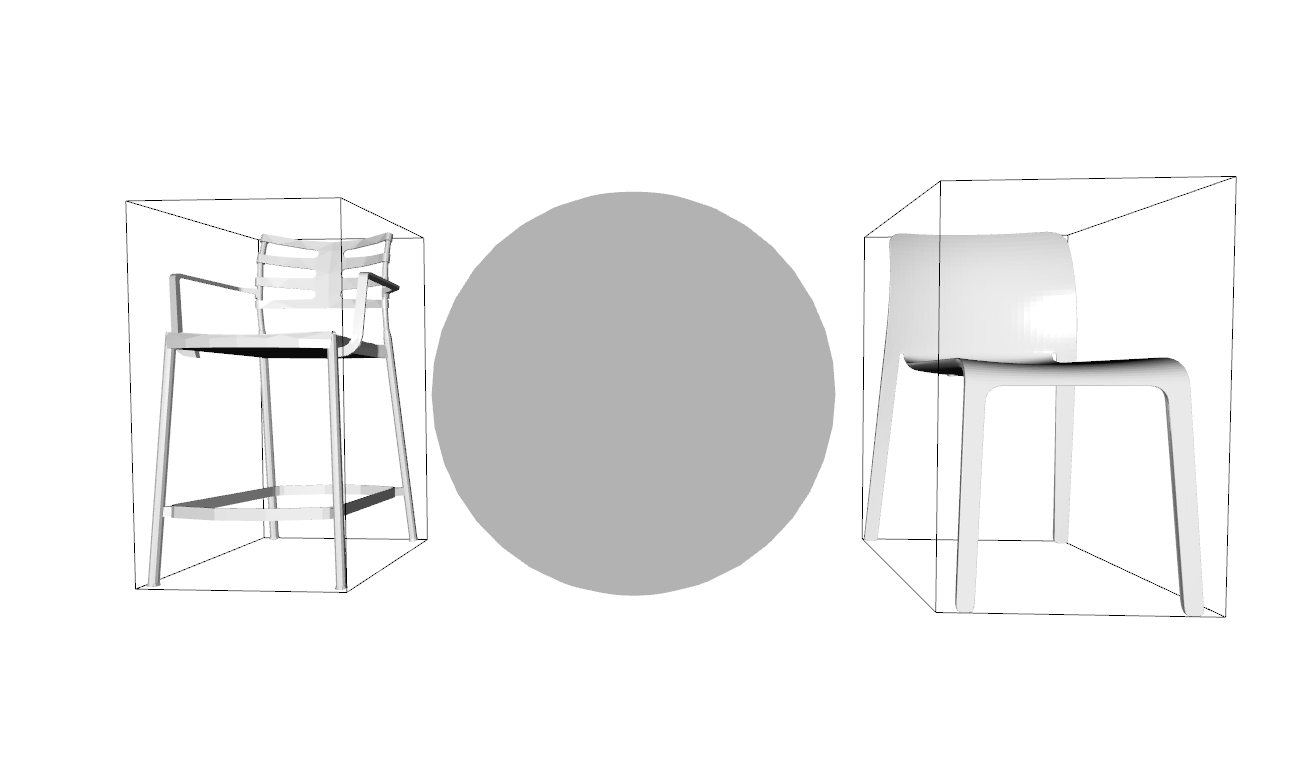

In [7]:
mesh1 = o3d.io.read_triangle_mesh('../tests/test_data/chair_0891.off')
mesh1.compute_vertex_normals()
bbox1 = mesh1.get_axis_aligned_bounding_box()
mesh2 = o3d.io.read_triangle_mesh('../tests/test_data/chair_0894.off')
mesh2.compute_vertex_normals()
bbox2 = mesh2.get_axis_aligned_bounding_box()
print("Before scaling:")
print("Volume of the mesh 1 = {:.2f}".format(bbox1.get_extent().prod()))
print("Volume of the mesh 2 = {:.2f}".format(bbox2.get_extent().prod()))

# let's add a unit_sphere as reference
unit_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
unit_sphere.translate([1.8, 0, 0])

mesh1_scaled = scale_mesh(mesh1)
bbox1_scaled = mesh1_scaled.get_axis_aligned_bounding_box()
mesh2_scaled = scale_mesh(mesh2)
mesh2_scaled.translate([3.7, 0, 0])
bbox2_scaled = mesh2_scaled.get_axis_aligned_bounding_box()
print("After scaling:")
print("Volume of the mesh 1 = {:.2f}".format(bbox1_scaled.get_extent().prod()))
print("Volume of the mesh 2 = {:.2f}".format(bbox2_scaled.get_extent().prod()))
o3d.visualization.draw_geometries([unit_sphere, mesh1_scaled, bbox1_scaled, mesh2_scaled, bbox2_scaled],
                                  mesh_show_back_face=True,
                                  front=[0.05, -1.0, 0.03],
                                  lookat=[1.91, 0.03, 0.03],
                                  up=[0.0, 0.03, 1.0],
                                  zoom=0.42)